# Import Library

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)

# Data processing

In [2]:
import scipy.io as scio
import pandas as pd

#input
feature1 = r'\Training dataset\ACC_UD.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_UD']
A=AA[:,0:300]

feature2 = r'\Training dataset\ACC_EW.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_EW']
B=BB[:,0:300]

feature3 = r'\Training dataset\ACC_NS.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_NS']
C=CC[:,0:300]

feature4 = r'\Training dataset\VEL_UD.mat'
data4 = scio.loadmat(feature4)
DD=data4['VEL_UD']
D=DD[:,0:300]

feature5 = r'\Training dataset\VEL_EW.mat'
data5 = scio.loadmat(feature5)
EE=data5['VEL_EW']
E=EE[:,0:300]

feature6 = r'\Training dataset\VEL_NS.mat'
data6 = scio.loadmat(feature6)
FF=data6['VEL_NS']
F=FF[:,0:300]

feature7 = r'\Training dataset\DIS_UD.mat'
data7 = scio.loadmat(feature7)
GG=data7['DIS_UD']
G=GG[:,0:300]

feature8 = r'\Training dataset\DIS_EW.mat'
data8 = scio.loadmat(feature8)
HH=data8['DIS_EW']
H=HH[:,0:300]

feature9 = r'\Training dataset\DIS_NS.mat'
data9 = scio.loadmat(feature9)
II=data9['DIS_NS']
I=II[:,0:300]


label = pd.read_csv(open(r'\Training dataset\lable.csv',encoding='UTF-8'))


In [3]:
raw_data1=np.hstack((A,B))
train_xx=np.hstack((raw_data1,C))


#print(train_xx.shape)


y_data=label.iloc[:,[1,3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_data[0])
#print(y_data.shape)

In [4]:
train_y=y_data[:,[1]] #y_train_lable
dis_train=y_data[:,[0]] #train_site_distance


#print(train_y.shape)
#print(dis_train.shape)



In [5]:
train_x=[]
for i in range(len(train_xx)):
    train_x.append(np.array(train_xx[i].reshape(3,1,300)).T)

In [6]:
train_dis=[]
for i in range(len(dis_train)):
    train_dis.append(np.array(dis_train[i].reshape(1,1,1)).T)

In [7]:
train_x=np.array(train_x)
train_dis=np.array(train_dis)
#test_x=np.array(test_x)

In [8]:
#3#  ##Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 300, 3))
train_dis = np.reshape(train_dis, (train_dis.shape[0], 1, 1))
#test_x = np.reshape(test_x, (test_x.shape[0], 300, 9))
#print("0",train_x.shape[0])
#print("1",train_x.shape[1])
#print(train_x.shape)
#print(train_x)

# LSTM-Mag architecture, training and testing

In [9]:
def LocalEncoder(x):


    e = tf.keras.layers.Bidirectional(LSTM(units = 100,kernel_regularizer=regularizers.l2(0.005),
                                                use_bias=True, return_sequences = True,
                                                name='GRU_1', #activation='relu',
                                               ))(x)

    e = tf.keras.layers.Bidirectional(LSTM(units = 50,kernel_regularizer=regularizers.l2(0.005),
                                                use_bias=True, return_sequences = True,
                                                name='GRU_1', #activation='relu',
                                               ))(x)
    
    return e
    
    

In [10]:
seed=50
from keras import regularizers 
from keras import initializers
#50 17.20 1.32
drop_rate = 0.2
def get_model():

    inp1 = Input(shape=(300, 3), name='input_layer') 

    x1 = LocalEncoder(inp1)


    e = tf.keras.layers.Flatten()(x1) # 打平层，方便全连接层处理
    e = layers.Dropout(rate=0.5)(e) #0.458

    e = tf.keras.layers.Dense(30,activation='relu')(e) # 全连接层，14节点  0.340 
    e = tf.keras.layers.Dense(10,activation='relu')(e) # 全连接层，14节点  0.340 
    o = tf.keras.layers.Dense(1)(e) # 全连接层，10 个节点 
    
    

    rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model = Model(inp1, o)
    model.compile(optimizer = rms, loss = 'mean_squared_error')

    return model

In [11]:
model = get_model()
model.summary() 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 300, 3)]          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 100)          21600     
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                900030    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [12]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor="val_loss",
                               factor=0.1,
                                cooldown= 0,
                                patience= 5,
                                min_lr=0.1e-7)
early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #10  17.20 1.32
callbacks = [lr_reducer, early_stopping_monitor]




model = get_model()
model.fit(train_x, train_y, epochs=300, batch_size=256,  
            validation_split=0.1, callbacks=callbacks)  #256 ,train_physics  ,test_physics ,train_physics

pred_train_all = model.predict(train_x).ravel()
#pred_test_all = model.predict(test_x).ravel()  ##ravel() 转换成1列


#pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
#pred_test_all = scaler_seq.inverse_transform(pred_test_all)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/300
162/162 [==============================] - 13s 77ms/step - loss: 1.6024 - val_loss: 0.6646
Epoch 2/300
162/162 [==============================] - 13s 80ms/step - loss: 0.4716 - val_loss: 0.4042
Epoch 3/300
162/162 [==============================] - 13s 81ms/step - loss: 0.3908 - val_loss: 0.3822
Epoch 4/300
162/162 [==============================] - 14s 85ms/step - loss: 0.3578 - val_loss: 0.3485
Epoch 5/300
162/162 [==============================] - 14s 84ms/step - loss: 0.3755 - val_loss: 0.4318
Epoch 6/300
162/162 [==============================] - 14s 85ms/step - loss: 0.3647 - val_loss: 0.3443
Epoch 7/300
162/162 [==============================] - 14s 85ms/step - loss: 0.3331 - val_loss: 0.4081
Epoch 8/300
162/162 [==============================] - 14s 84ms/step - loss: 0.3795 - val_loss: 0.3769
Epoch 9/300
162/162 [==============================] - 14s 84ms/step - loss: 0.3327 - val_loss: 0.3587
Epoch 10/300
162/162 [==============================] - 14s 84ms/step - l

In [13]:
# 保存权重（推荐方式）
model.save_weights("LSTM_Mag_weights.h5")  # HDF5格式

In [14]:
def get_model_size_mb(model):
    params = model.count_params()
    # 假设所有参数为float32（4字节）
    size_mb = params * 4 / 1024**2
    return size_mb
 
print("Model size (MB):", get_model_size_mb(model))

Model size (MB): 3.5169639587402344


训练标准差STD= 0.40120087655256503
训练误差均值MEAN= -0.00999410211358565
训练平均绝对误差MAE= 0.2917899892793509
训练RMSE= 0.4013253361346668
训练MAPE= 6.73595170945242
训练r2 score: 0.8428381122765068


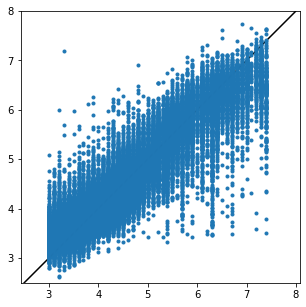

In [15]:
from sklearn import metrics
from sklearn.metrics import r2_score
print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2.5, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(2.5, 8)
plt.ylim(2.5, 8)
plt.show()

In [16]:
#########################保存训练结果####################################
pred_train_all=pred_train_all.reshape(pred_train_all.shape[0],1)

#y_score_tr=y_score_tr.reshape(y_score_tr.shape[0],1)
#print(pred_train_all.shape)
#print(train_y.shape)

tr_result=np.concatenate((train_y,pred_train_all),axis=1)

#print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['True M','Pred M']
writer_tr = pd.ExcelWriter(r'\LSTM-Mag\magtrain.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()
#########################保存训练结果####################################

In [17]:
#震例
import scipy.io as scio
import pandas as pd

#input
feature1z = r'\Test dataset\ACC_UD.mat'
data1z = scio.loadmat(feature1z)
AAz=data1z['ACC_UD']
Az=AAz[:,0:300]

feature2z = r'\Test dataset\ACC_EW.mat'
data2z = scio.loadmat(feature2z)
BBz=data2z['ACC_EW']
Bz=BBz[:,0:300]

feature3z = r'\Test dataset\ACC_NS.mat'
data3z = scio.loadmat(feature3z)
CCz=data3z['ACC_NS']
Cz=CCz[:,0:300]

feature4z = r'\Test dataset\VEL_UD.mat'
data4z = scio.loadmat(feature4z)
DDz=data4z['VEL_UD']
Dz=DDz[:,0:300]

feature5z = r'\Test dataset\VEL_EW.mat'
data5z = scio.loadmat(feature5z)
EEz=data5z['VEL_EW']
Ez=EEz[:,0:300]

feature6z = r'\Test dataset\VEL_NS.mat'
data6z = scio.loadmat(feature6z)
FFz=data6z['VEL_NS']
Fz=FFz[:,0:300]

feature7z = r'\Test dataset\DIS_UD.mat'
data7z = scio.loadmat(feature7z)
GGz=data7z['DIS_UD']
Gz=GGz[:,0:300]

feature8z = r'\Test dataset\DIS_EW.mat'
data8z = scio.loadmat(feature8z)
HHz=data8z['DIS_EW']
Hz=HHz[:,0:300]

feature9z = r'\Test dataset\DIS_NS.mat'
data9z = scio.loadmat(feature9z)
IIz=data9z['DIS_NS']
Iz=IIz[:,0:300]


labelz = pd.read_csv(open(r'\Test dataset\lable.csv',encoding='UTF-8'))


In [18]:
raw_data1z=np.hstack((Az,Bz))
x_dataz=np.hstack((raw_data1z,Cz))


y_dataz=labelz.iloc[:,[1,3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_dataz[0])
#print(y_dataz.shape)

In [19]:
zhenli_y=y_dataz[:,[1]] #y_train_lable
dis_zhenli=y_dataz[:,[0]] #train_site_distance



In [20]:
zhenli_x=[]
for i in range(len(x_dataz)):
    zhenli_x.append(np.array(x_dataz[i].reshape(3,1,300)).T)

In [21]:
zhenli_dis=[]
for i in range(len(dis_zhenli)):
    zhenli_dis.append(np.array(dis_zhenli[i].reshape(1,1,1)).T)



In [22]:
zhenli_x=np.array(zhenli_x)
zhenli_dis=np.array(zhenli_dis)

In [23]:
zhenli_x = np.reshape(zhenli_x, (zhenli_x.shape[0], 300, 3))
zhenli_dis = np.reshape(zhenli_dis, (zhenli_dis.shape[0], 1, 1))

In [22]:

zhenli_x1=zhenli_x[0]
zhenli_x1=zhenli_x1.reshape(1, 300, 3)
print(zhenli_x1.shape)

(1, 300, 3)


In [30]:
import time
start_time = time.perf_counter()  # 记录开始时间
pred_zhenli_all = model.predict(zhenli_x1).ravel()  ##ravel() 转换成1列
end_time = time.perf_counter()  # 记录结束时间
elapsed_time_ms = (end_time - start_time) * 1000  # 转换为毫秒
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")

Elapsed time: 59.65 ms


震例标准差STD= 0.4216588283954194
震例误差均值MEAN= -0.05611222497413943
震例平均绝对误差MAE= 0.3166783289097282
震例RMSE= 0.4253760093791682
震例MAPE= 7.336078954626951
震例r2 score: 0.8119013513230751


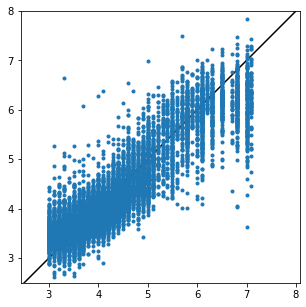

In [24]:
pred_zhenli_all = model.predict(zhenli_x).ravel()  ##ravel() 转换成1列
print("震例标准差STD=",np.std(pred_zhenli_all-zhenli_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all-zhenli_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all, zhenli_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all, zhenli_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y.ravel() - pred_zhenli_all) / zhenli_y.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y.ravel(), pred_zhenli_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2.5, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y.ravel(),pred_zhenli_all,'.')
plt.xlim(2.5, 8)
plt.ylim(2.5, 8)
plt.show()  

In [25]:
#########################保存震例结果####################################
pred_zhenli_all=pred_zhenli_all.reshape(pred_zhenli_all.shape[0],1)

#print(pred_zhenli_all.shape)
#print(zhenli_y.shape)

tz_result=np.concatenate((zhenli_y,pred_zhenli_all),axis=1)

#print(tz_result.shape)

data_tz = pd.DataFrame(tz_result) #将数组转换为dataframe结构
data_tz.columns=['True M','Pred M']
writer_tz = pd.ExcelWriter(r'\LSTM-Mag\magtest.xls')   # 写入Excel文件

data_tz.to_excel(writer_tz,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz.save()
writer_tz.close()
#########################保存震例结果####################################

# Test on the Chinese strong-ground motion data

In [26]:
#在中国地区的应用
import scipy.io as scio
import pandas as pd

#input
feature1z_CH = r'\Chinese strong-ground motion test dataset\ACC_UD.mat'
data1z_CH = scio.loadmat(feature1z_CH)
AAz_CH=data1z_CH['ACC_UD']
Az_CH=AAz_CH[:,0:300]

feature2z_CH = r'\Chinese strong-ground motion test dataset\ACC_EW.mat'
data2z_CH = scio.loadmat(feature2z_CH)
BBz_CH=data2z_CH['ACC_EW']
Bz_CH=BBz_CH[:,0:300]

feature3z_CH = r'\Chinese strong-ground motion test dataset\ACC_NS.mat'
data3z_CH = scio.loadmat(feature3z_CH)
CCz_CH=data3z_CH['ACC_NS']
Cz_CH=CCz_CH[:,0:300]

feature4z_CH = r'\Chinese strong-ground motion test dataset\VEL_UD.mat'
data4z_CH = scio.loadmat(feature4z_CH)
DDz_CH=data4z_CH['VEL_UD']
Dz_CH=DDz_CH[:,0:300]

feature5z_CH = r'\Chinese strong-ground motion test dataset\VEL_EW.mat'
data5z_CH = scio.loadmat(feature5z_CH)
EEz_CH=data5z_CH['VEL_EW']
Ez_CH=EEz_CH[:,0:300]

feature6z_CH = r'\Chinese strong-ground motion test dataset\VEL_NS.mat'
data6z_CH = scio.loadmat(feature6z_CH)
FFz_CH=data6z_CH['VEL_NS']
Fz_CH=FFz_CH[:,0:300]

feature7z_CH = r'\Chinese strong-ground motion test dataset\DIS_UD.mat'
data7z_CH = scio.loadmat(feature7z_CH)
GGz_CH=data7z_CH['DIS_UD']
Gz_CH=GGz_CH[:,0:300]

feature8z_CH = r'\Chinese strong-ground motion test dataset\DIS_EW.mat'
data8z_CH = scio.loadmat(feature8z_CH)
HHz_CH=data8z_CH['DIS_EW']
Hz_CH=HHz_CH[:,0:300]

feature9z_CH = r'\Chinese strong-ground motion test dataset\DIS_NS.mat'
data9z_CH = scio.loadmat(feature9z_CH)
IIz_CH=data9z_CH['DIS_NS']
Iz_CH=IIz_CH[:,0:300]


labelz_CH = pd.read_csv(open(r'\Chinese strong-ground motion test dataset\lable.csv',encoding='UTF-8'))


In [27]:
raw_data1z_CH=np.hstack((Az_CH,Bz_CH))
x_dataz_CH=np.hstack((raw_data1z_CH,Cz_CH))


y_dataz_CH=labelz_CH.iloc[:,[1,3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_dataz_CH[0])
#print(y_dataz_CH.shape)

In [28]:
zhenli_y_CH=y_dataz_CH[:,[1]] #y_train_lable
dis_zhenli_CH=y_dataz_CH[:,[0]] #train_site_distance

In [29]:
zhenli_x_CH=[]
for i in range(len(x_dataz_CH)):
    zhenli_x_CH.append(np.array(x_dataz_CH[i].reshape(3,1,300)).T)

In [30]:
zhenli_x_CH=np.array(zhenli_x_CH)
zhenli_x_CH = np.reshape(zhenli_x_CH, (zhenli_x_CH.shape[0], 300, 3))

In [31]:
pred_zhenli_all_CH = model.predict(zhenli_x_CH).ravel()  ##ravel() 转换成1列

震例标准差STD= 0.48666690208736724
震例误差均值MEAN= 0.18724003937569886
震例平均绝对误差MAE= 0.4101273576859787
震例RMSE= 0.5214436747461114
震例MAPE= 9.448596242862564
震例r2 score: 0.5753744955098543


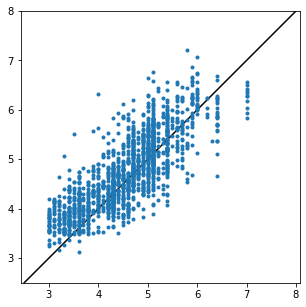

In [32]:
print("震例标准差STD=",np.std(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all_CH, zhenli_y_CH.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all_CH, zhenli_y_CH.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y_CH.ravel() - pred_zhenli_all_CH) / zhenli_y_CH.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y_CH.ravel(), pred_zhenli_all_CH))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2.5, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y_CH.ravel(),pred_zhenli_all_CH,'.')
plt.xlim(2.5, 8)
plt.ylim(2.5, 8)
plt.show()  